# Sample and Visualize the Trained DDPM Model

In this notebook, we load the pretrained diffusion model and sample from it. 

The diffusion model was trained a set of 200 simulation states comprised of marker field, velocity field, and obstacle mask at simulation time t=0.35. 
There is no noise for the obstacle masks, and they are concatenated with the other three input channels. 
Sampled states are visualized in this notebook.

### Load the trained model
Define model architecture of Unet:
 - channels: 4 channels in the input image (obstacle mask, marker field, velocity in x direction, velocity in y direction)
 - image_size: 64x64

In [1]:
import torch

import sys
sys.path.append('github/smdp/buoyancy-flow/baselines/diffusion-posterior-sampling') 
from unet import Unet


model_spec = {'channels': 4,
              'image_size': 64,
              'data_shape': (4, 64, 64),
              'dim' : 64,
              'dim_mults' : (1, 2, 2, 4,)}


model = Unet(**model_spec)

Load the pretrained model weights

In [2]:
# file path for stored weights
weight_file = 'github/diffusion-posterior-sampling-backup/results/ddpm-model-flow-2s3jcppm-20.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = torch.load(weight_file,
                  map_location=device)
model.load_state_dict(data['model'])
model = model.to(device)

### Sample from the trained model
Before sampling, we define a mask for the obstacles which is used to condition the sampling. The mask is a 64x64 image with 1s in the obstacle region and 0s in the rest of the image.

In [3]:
# define mask for obstacles
obstacle_mask = torch.zeros((1, 64, 64)).to(device)

In [4]:
from sample import conditional_sampling
import numpy as np

samples = conditional_sampling(model, obstacle_mask, device)
samples = samples[0].cpu().numpy()
samples = np.flip(samples, axis=1)

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.99it/s]


### Visualize data velocity and smoke/marker field

Visualize marker field and velocity in x direction. The mask field is visualized as well. The mask field is to show the obstacles.

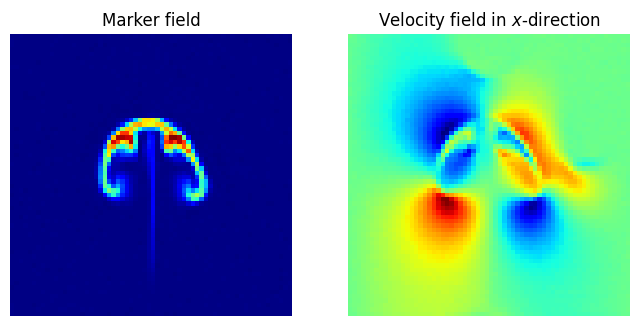

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

marker_field = samples[1]
velocity_x = samples[2]
velocity_y = samples[3]
mask = samples[0]

vmin = np.min(marker_field)
vmax = np.max(marker_field)
marker_with_mask = marker_field + mask * vmax
axes[0].imshow(marker_field, cmap='jet', vmin = vmin, vmax = vmax)
axes[0].set_axis_off()
axes[0].set_title('Marker field')   

vmin = np.min(velocity_x)
vmax = np.max(velocity_x)
vel_x_with_mask = velocity_x + mask * vmax
axes[1].imshow(vel_x_with_mask, cmap='jet', vmin = vmin, vmax = vmax)
axes[1].set_axis_off()
axes[1].set_title(r'Velocity field in $x$-direction')

plt.show()